In [1]:
import csv
import sys
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import math
from tqdm import tqdm
import py_stringmatching as sm
import pickle
import numpy as np
from numpy import dot
from numpy.linalg import norm
csv.field_size_limit(sys.maxsize)
import random


In [3]:
with open('qqpSimilarity.pkl', 'rb') as file:
    readList = pickle.load(file)

In [6]:
def randomSample(size, pool):
    randomSample = random.choices(pool, k=size)
    posCounter = 0
    for s in randomSample:
        if s[3] == 1:
            posCounter += 1
    return posCounter / size

def importanceSample(size, pool, weight,sumWeight,weightIdx):
    sample = random.choices(pool, weights=weight,k=size)
    mean = 0
    for s in sample:
        if s[3] == 1:
            mean += sumWeight / (len(pool) * s[weightIdx])
    return mean/size

numTrail = 20
totalSizeList = [1000000,10000000]

cosWeight = [r[0] for r in readList]
cosWeightSum = sum(cosWeight)
tfIdfWeight = [r[1] for r in readList]
tfIdfWeightSum = sum(tfIdfWeight)
resultList = []
for totalSize in totalSizeList:
    randomMean = []
    cosMean = []
    tfIdfMean = []
    for _ in range(numTrail):
        randomResult = len(readList) * randomSample(size=totalSize,pool=readList)
        cosResult = len(readList) * importanceSample(size = totalSize, pool = readList,weight=cosWeight,sumWeight=cosWeightSum,weightIdx=0)
        tfIdfResult = len(readList) * importanceSample(size=totalSize,pool=readList,weight=tfIdfWeight,sumWeight=tfIdfWeightSum,weightIdx=1)

        randomMean.append(randomResult)
        cosMean.append(cosResult)
        tfIdfMean.append(tfIdfResult)
    print(np.mean(randomMean))
    print(np.mean(cosMean))
    print(np.mean(tfIdfMean))
    result = (np.var(randomMean),np.var(cosMean),np.var(tfIdfMean))
    print(result)
    resultList.append(result)

with open('varianceResult.pkl', 'wb') as file:
      pickle.dump(resultList, file)

2450.35
2844.9307927908003
2407.1664810271423
(1739997.0354999998, 1206071.8736483823, 94004.47318494963)


In [4]:
companyBlockingWeightFirst = [(r[2],r[3]) for r in readList]
companyBlockingWeightFirst.sort(reverse=True)

In [5]:

totalPos = 0
for b in companyBlockingWeightFirst:
    if b[1] == 1:
        totalPos += 1

In [6]:
threasholdSizeList = [5000,10000,50000,100000,500000,1000000,10000000]
recall = []
fp = []
fn = []
for thresholdSize in threasholdSizeList:
    upperPos = 0
    for b in companyBlockingWeightFirst[:thresholdSize]:
        if b[1] == 1:
            upperPos += 1
    recall.append(upperPos/totalPos)
    fp.append((thresholdSize-upperPos)/thresholdSize)
    fn.append(upperPos/(len(companyBlockingWeightFirst) - thresholdSize))



In [24]:
recall

[0.0,
 0.0,
 0.6235119047619048,
 0.8705357142857143,
 0.9970238095238095,
 1.0,
 1.0]

In [8]:
with open('qqpGraph.pkl', 'rb') as file:
    readList = pickle.load(file)
recall,fp,fn = readList
totalSize = 100000000
threasholdSizeList = [5000/totalSize,10000/totalSize,50000/totalSize,100000/totalSize,500000/totalSize,1000000/totalSize,10000000/totalSize]


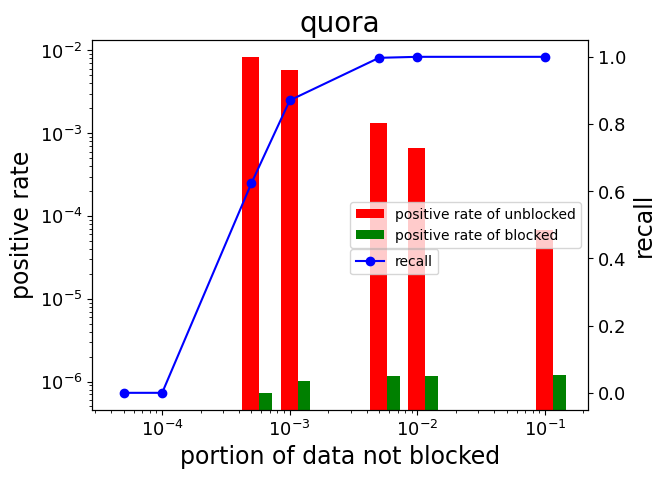

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data
x = threasholdSizeList
y1 = recall
y2 = [1-fp[i] for i in range(len(fp))]
width = [0.3 * a for a in x]
y3 = fn
fig, ax1 = plt.subplots()
# Plot the lines

ax2 = ax1.twinx()
ax2.plot(x, y1, color='blue', marker='o', label='recall')
ax1.bar(x, y2, color='red',  label='positive rate of unblocked',width=width)
ax1.bar([x[i]+width[i] for i in range(len(x))], y3, color='green',  label='positive rate of blocked',width=width)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)

# Set log scale on x-axis
plt.xscale('log')
#plt.gca().invert_xaxis()

ax1.set_yscale('log')

# Add labels and legend
ax1.set_xlabel('portion of data not blocked', fontsize = 17)
ax1.set_ylabel('positive rate',fontsize = 17)
ax2.set_ylabel('recall', fontsize = 17)
plt.title('quora',fontsize=20)
ax1.legend(loc='center right').set_zorder(2)
ax2.legend(loc='center right',bbox_to_anchor=(0.712, 0.4)).set_zorder(2)

# Show the plot
plt.show()


In [44]:
with open('qqpvarianceResult.pkl', 'rb') as file:
    readList = pickle.load(file)
print(readList)

[(348148.0445137072, 52622.97538938464, 22894.123934912084, 16276.713441367592), (44495.61917971177, 4216.922691982068, 1403.7466227586071, 2314.3498806836956)]


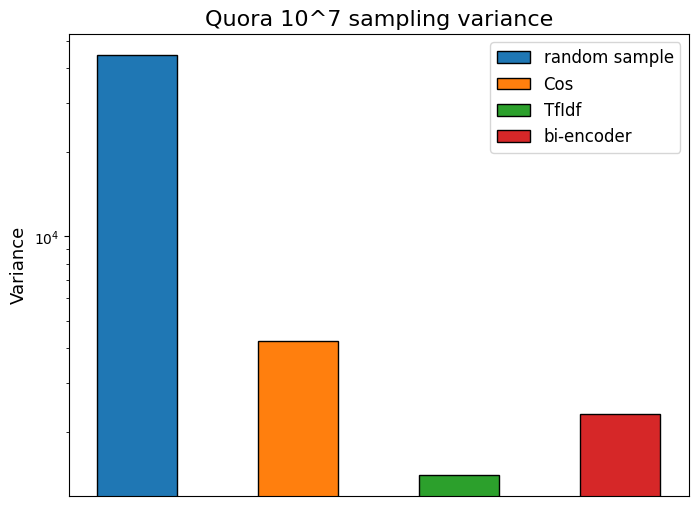

In [45]:
import matplotlib.pyplot as plt
import numpy as np


# Increase the figure size
plt.figure(figsize=(8, 6))

# Plot the bar graph with a blank x-axis
plt.bar(0, readList[1][0],label='random sample', edgecolor='black',width=0.5)
plt.bar(1, readList[1][1],label='Cos', edgecolor='black',width=0.5)
plt.bar(2, readList[1][2],label='TfIdf', edgecolor='black',width=0.5)
plt.bar(3, readList[1][3],label='bi-encoder', edgecolor='black',width=0.5)

# Add labels and title
plt.ylabel('Variance',fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12)

frame1 = plt.gca()

frame1.axes.get_xaxis().set_visible(False)
plt.title('Quora 10^7 sampling variance',fontsize=16)

# Show the plot
plt.show()
